In [1]:
import torch
from torch import nn
import torchvision
import numpy as np
#!pip install timm
import timm
import os
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from torchvision.datasets import ImageFolder
import operator
import torchvision.transforms as transforms 
import seaborn as sns

from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.ticker as ticker
import itertools

In [2]:
#test -> validation set
#pred -> test set (not labelled)
train_dir = r"C:\Users\siddh\Downloads\Image\train"
test_dir = r"C:\Users\siddh\Downloads\Image\test"


BATCH_SIZE = 64
EPOCHS = 9
CLASSES = os.listdir(train_dir)
metric = 0

In [8]:
device = torch.device('cpu' if torch.cuda.is_available else 'cuda')
device

device(type='cpu')

In [9]:
def model_adjustment(p_model):
    for param in p_model.parameters():
        param.requires_grad=False
    return p_model

In [10]:
def model_assets(base_model, seed):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(base_model.parameters(), lr=0.001)
    lrp_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
    if seed == 0 or seed == 1:
        mls_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2], gamma=0.1)
        return criterion, optimizer, lrp_scheduler, mls_scheduler
    else:
        return criterion, optimizer, lrp_scheduler

In [ ]:
DEFINING MODEL

In [11]:
def model_archive(seed):
    if seed == 0:
        model = torchvision.models.vgg19_bn(pretrained=True)
        model = model_adjustment(model)
        in_features = model.classifier[0].in_features
        model.classifier = nn.Sequential(
            nn.Linear(in_features, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=4096, out_features=len(CLASSES)),
        )
        model.to(device)
        criterion, optimizer, lrp_scheduler, mls_scheduler = model_assets(model, seed) 
        return model, criterion, optimizer, lrp_scheduler, mls_scheduler
    
    elif seed == 1:
        model = timm.create_model('vit_base_patch16_224', pretrained=True)
        model = model_adjustment(model)
        in_features = model.head.in_features
        model.head = nn.Linear(in_features, out_features=len(CLASSES), bias=True)
        model.to(device)
        criterion, optimizer, lrp_scheduler, mls_scheduler = model_assets(model, seed)
        return model, criterion, optimizer, lrp_scheduler, mls_scheduler
    
    elif seed == 2:
        model = timm.create_model('ens_adv_inception_resnet_v2', pretrained=True)
        model = model_adjustment(model)
        in_features = model.classif.in_features
        model.classif = nn.Linear(in_features, out_features=len(CLASSES), bias=True)
        model.to(device)
        criterion, optimizer, lrp_scheduler = model_assets(model, seed)
        return model, criterion, optimizer, lrp_scheduler
    
    elif seed == 3:
        model = torchvision.models.densenet201(pretrained=True)
        model = model_adjustment(model)
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, out_features=len(CLASSES), bias=True)
        model.to(device)
        criterion, optimizer, lrp_scheduler = model_assets(model, seed)
        return model, criterion, optimizer, lrp_scheduler
    
    elif seed == 4:
        model = torchvision.models.resnext50_32x4d(pretrained=True)
        model = model_adjustment(model)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, out_features=len(CLASSES), bias=True)
        model.to(device)
        criterion, optimizer, lrp_scheduler = model_assets(model, seed)
        return model, criterion, optimizer, lrp_scheduler

In [12]:
# VGG19 with batch-normalization
model_vgg, criterion_vgg, optimizer_vgg, lrp_scheduler_vgg, mls_scheduler_vgg = model_archive(seed = 0)

# ViT (Vision Transformer)
model_vit, criterion_vit, optimizer_vit, lrp_scheduler_vit, mls_scheduler_vit = model_archive(seed = 1)

# Ensemble Adversarial Inception-ResNet v2
model_eairv, criterion_eairv, optimizer_eairv, lrp_scheduler_eairv = model_archive(seed = 2)

# DenseNet201 classifier
model_dn, criterion_dn, optimizer_dn, lrp_scheduler_dn = model_archive(seed = 3)

# ResNeXt50_32 Classifier
model_rnx, criterion_rnx, optimizer_rnx, lrp_scheduler_rnx = model_archive(seed = 4)

In [ ]:
Transformation nd augmentations

In [13]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [14]:
transform_train_v1 = torchvision.transforms.Compose([
    transforms.Resize(size=256, interpolation=transforms.functional.InterpolationMode('bicubic'), max_size=None, antialias=None),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=([0.4850, 0.4560, 0.4060]), std=([0.2290, 0.2240, 0.2250])),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), inplace=False),
    transforms.RandomApply([AddGaussianNoise(0., 0.156)], p=0.5),
])
transform_test_v1 = torchvision.transforms.Compose([
    transforms.Resize(size=256, interpolation=transforms.functional.InterpolationMode('bicubic'), max_size=None, antialias=None),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=([0.4850, 0.4560, 0.4060]), std=([0.2290, 0.2240, 0.2250])),
])

In [15]:
config_vit = resolve_data_config({}, model = model_vit)
transform_vit = create_transform(**config_vit)

config_eairv = resolve_data_config({}, model = model_eairv)
transform_eairv = create_transform(**config_eairv)

C:\Users\siddh\anaconda3\lib\site-packages\torchvision\transforms\transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [ ]:
Loading Data

In [17]:
train_data_v1 = ImageFolder(train_dir, transform = transform_train_v1)
test_data_v1 = ImageFolder(test_dir, transform = transform_test_v1)
#loading data for VGG19 BatchNorm, DenseNet201, ResNeXt50
train_loader_v1 = torch.utils.data.DataLoader(train_data_v1, BATCH_SIZE, shuffle=True)
test_loader_v1 = torch.utils.data.DataLoader(test_data_v1, BATCH_SIZE, shuffle=False)


train_data_vit = ImageFolder(train_dir, transform = transform_vit)
test_data_vit = ImageFolder(test_dir, transform = transform_vit)
#loading data for ViT
train_loader_vit = torch.utils.data.DataLoader(train_data_vit, BATCH_SIZE, shuffle=True)
test_loader_vit = torch.utils.data.DataLoader(test_data_vit, BATCH_SIZE, shuffle=False)


train_data_eairv = ImageFolder(train_dir, transform = transform_eairv)
test_data_eairv = ImageFolder(test_dir, transform = transform_eairv)
#loading data for Ensemble Adversarial Inception-ResNetV2
train_loader_eairv = torch.utils.data.DataLoader(train_data_eairv, BATCH_SIZE, shuffle=True)
test_loader_eairv = torch.utils.data.DataLoader(test_data_eairv, BATCH_SIZE, shuffle=False)

In [ ]:
Function to return predections

In [18]:
def predictions_df(dl_model, test_loader, transform_obj):
    pred_hard, pred_soft = [], []
    correct_count, all_count = 0,0
    dl_model.eval()
    im_dim = transform_obj.transforms[1].size[0]
    with torch.no_grad():
        for images, labels in test_loader:
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            for i in range(len(labels)):
                img = images[i].view(1, 3, im_dim, im_dim)
                # soft voting
                output = dl_model(img)
                sm = nn.Softmax(dim=1)
                probabilities = sm(output)
                prob_arr = (probabilities.detach().cpu().numpy())[0]
                # hard voting
                logps = dl_model(img)
                ps = torch.exp(logps)
                probab = list(ps.cpu()[0])
                pred_label = probab.index(max(probab))
                true_label = labels.cpu()[i]
                #exporting to dataframe
                pred_hard.append(pred_label)
                pred_soft.append(prob_arr)
                ####
                if(true_label == pred_label):
                    correct_count += 1
                all_count += 1

    print("Number of images Tested=", all_count)
    print("Model Accuracy=",(correct_count/all_count)*100)
    print("\n")
    return pred_hard, pred_soft

In [ ]:
Training

In [19]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs, seed, model_name, lrp_scheduler, mls_scheduler=None):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        t0 = datetime.now()
        model.train()
        train_loss = []
        train_total = 0
        train_correct = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            # move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            _, train_predict = torch.max(outputs.data, 1)
            loss = criterion(outputs, targets)
            # Backward and optimize
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            train_total += targets.size(0)
            train_correct += (train_predict == targets).sum().item()

        else:
            model.eval()
            test_loss = []
            test_total = 0
            test_correct = 0
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, test_predict = torch.max(outputs.data, 1)
                loss = criterion(outputs, targets)
                test_loss.append(loss.item())
                test_total += targets.size(0)
                test_correct += (test_predict == targets).sum().item()
            #get train and test loss
            test_loss = np.mean(test_loss)
            train_loss = np.mean(train_loss)
            #scheduler ReduceLROnPlateau and MultiStepLR
            lrp_scheduler.step(metric)
            if seed == 0 or seed == 1:
                mls_scheduler.step()
            ###    
            print('learning_rate: {}'.format(optimizer.state_dict()['param_groups'][0]['lr']))
            # Save losses
            train_losses[it] = train_loss
            test_losses[it] = test_loss

            dt = datetime.now() - t0
            print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Acc: {(100*train_correct/train_total):.4f}, \
                    Test Loss: {test_loss:.4f}, Test Acc: {(100*test_correct/test_total):.4f}, Duration: {dt}')
    return train_losses, test_losses

In [20]:
print('Model: VGG-19-BN')
loss_train_vgg, loss_test_vgg = batch_gd(model_vgg, criterion_vgg, optimizer_vgg, train_loader_v1, test_loader_v1, EPOCHS, 0, 'vgg_dict.pth', lrp_scheduler_vgg, mls_scheduler_vgg)
print('\nModel: DenseNet201')
loss_train_dn, loss_test_dn = batch_gd(model_dn, criterion_dn, optimizer_dn, train_loader_v1, test_loader_v1, EPOCHS, 2, 'dn_dict.pth', lrp_scheduler_dn)
print('\nModel: ResNeXt50')
loss_train_rnx, loss_test_rnx = batch_gd(model_rnx, criterion_rnx, optimizer_rnx, train_loader_v1, test_loader_v1, EPOCHS, 4, 'rnx_dict.pth', lrp_scheduler_rnx)

Model: VGG-19-BN
learning_rate: 0.001
Epoch 1/9, Train Loss: 0.2471, Acc: 93.5734,                     Test Loss: 0.0888, Test Acc: 96.7485, Duration: 3:22:28.515310
learning_rate: 0.0001
Epoch 2/9, Train Loss: 0.0901, Acc: 96.9913,                     Test Loss: 0.0772, Test Acc: 97.7936, Duration: 3:25:22.674792
learning_rate: 0.0001
Epoch 3/9, Train Loss: 0.0466, Acc: 98.3463,                     Test Loss: 0.0667, Test Acc: 98.1586, Duration: 3:28:33.858580
learning_rate: 1e-05
Epoch 4/9, Train Loss: 0.0409, Acc: 98.6284,                     Test Loss: 0.0723, Test Acc: 98.1918, Duration: 3:30:07.399762
learning_rate: 1e-05
Epoch 5/9, Train Loss: 0.0371, Acc: 98.6450,                     Test Loss: 0.0694, Test Acc: 98.1586, Duration: 3:29:52.371871
learning_rate: 1e-05
Epoch 6/9, Train Loss: 0.0369, Acc: 98.6616,                     Test Loss: 0.0690, Test Acc: 98.1918, Duration: 3:36:10.172712
learning_rate: 1.0000000000000002e-06
Epoch 7/9, Train Loss: 0.0359, Acc: 98.7335,     

In [21]:
 print('\nModel: Vision Transformer - ViT')
loss_train_vit, loss_test_vit = batch_gd(model_vit, criterion_vit, optimizer_vit, train_loader_vit, test_loader_vit, EPOCHS, 1, 'vit_dict.pth', lrp_scheduler_vit, mls_scheduler_vit)


Model: Vision Transformer - ViT
learning_rate: 0.001
Epoch 1/9, Train Loss: 0.1749, Acc: 93.7614,                     Test Loss: 0.1285, Test Acc: 95.4545, Duration: 3:00:24.826075
learning_rate: 0.0001
Epoch 2/9, Train Loss: 0.1056, Acc: 96.6263,                     Test Loss: 0.1005, Test Acc: 96.7153, Duration: 3:02:28.702372
learning_rate: 0.0001
Epoch 3/9, Train Loss: 0.0880, Acc: 97.2181,                     Test Loss: 0.0991, Test Acc: 96.6490, Duration: 3:27:55.332574
learning_rate: 1e-05
Epoch 4/9, Train Loss: 0.0870, Acc: 97.2623,                     Test Loss: 0.0999, Test Acc: 96.6656, Duration: 3:32:28.178188
learning_rate: 1e-05
Epoch 5/9, Train Loss: 0.0846, Acc: 97.3397,                     Test Loss: 0.0973, Test Acc: 96.6821, Duration: 3:28:26.832539
learning_rate: 1e-05
Epoch 6/9, Train Loss: 0.0847, Acc: 97.3674,                     Test Loss: 0.0972, Test Acc: 96.6987, Duration: 3:29:11.181455
learning_rate: 1.0000000000000002e-06
Epoch 7/9, Train Loss: 0.0845, Ac

In [22]:
print('\nModel: Ensemble Adverserial Inception-Resnet-V2')
loss_train_eairv, loss_test_eairv = batch_gd(model_eairv, criterion_eairv, optimizer_eairv, train_loader_eairv, test_loader_eairv, EPOCHS, 3, 'eairv_dict.pth', lrp_scheduler_eairv)


Model: Ensemble Adverserial Inception-Resnet-V2
learning_rate: 0.001
Epoch 1/9, Train Loss: 0.2303, Acc: 91.3998,                     Test Loss: 0.1700, Test Acc: 94.2933, Duration: 3:53:27.400539
learning_rate: 0.001
Epoch 2/9, Train Loss: 0.1663, Acc: 94.0711,                     Test Loss: 0.1522, Test Acc: 94.4592, Duration: 3:46:40.144365
learning_rate: 0.001
Epoch 3/9, Train Loss: 0.1507, Acc: 94.5689,                     Test Loss: 0.1402, Test Acc: 94.8739, Duration: 3:48:22.281690
learning_rate: 0.0001
Epoch 4/9, Train Loss: 0.1445, Acc: 94.8178,                     Test Loss: 0.1397, Test Acc: 94.8242, Duration: 3:48:04.089245
learning_rate: 0.0001
Epoch 5/9, Train Loss: 0.1353, Acc: 94.9505,                     Test Loss: 0.1360, Test Acc: 94.9569, Duration: 3:41:25.719348
learning_rate: 0.0001
Epoch 6/9, Train Loss: 0.1323, Acc: 95.1164,                     Test Loss: 0.1319, Test Acc: 95.0398, Duration: 3:51:41.640787
learning_rate: 1e-05
Epoch 7/9, Train Loss: 0.1346, Ac

In [ ]:
Predictions

In [23]:
#predictions for each model (pred_hard, pred_soft)
vgg19_bn_hard, vgg19_bn_soft = predictions_df(model_vgg, test_loader_v1, transform_test_v1)
vit_hard, vit_soft = predictions_df(model_vit, test_loader_vit, transform_vit)
densenet201_hard, densenet201_soft = predictions_df(model_dn, test_loader_v1, transform_test_v1)
ensemble_adv_incres_v2_hard, ensemble_adv_incres_v2_soft = predictions_df(model_eairv, test_loader_eairv, transform_eairv)
resnext50_hard, resnext50_soft = predictions_df(model_rnx, test_loader_v1, transform_test_v1)
true_labels = []
#getting true labels
for _, labels in test_loader_v1:
    for x in range(len(labels)):
        true_labels.append(labels[x].item())

Number of images Tested= 6028
Model Accuracy= 98.15859323158594


Number of images Tested= 6028
Model Accuracy= 96.6821499668215


Number of images Tested= 6028
Model Accuracy= 95.28865295288654


Number of images Tested= 6028
Model Accuracy= 94.95686794956868


Number of images Tested= 6028
Model Accuracy= 95.05640345056403




In [ ]:
Plotting losses - accuracy

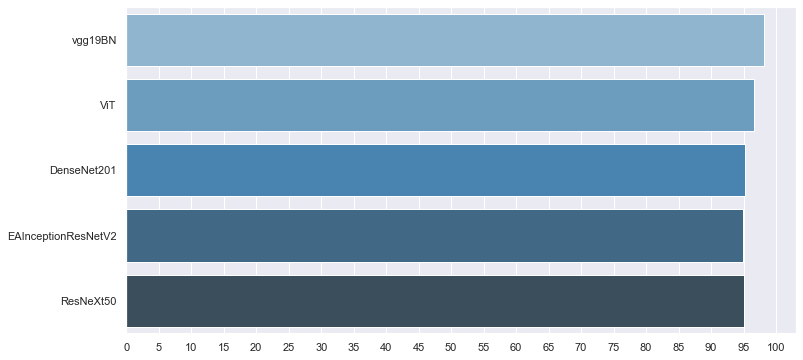

In [24]:
def plot_model_accuracies():
    scores = []
    model_acc = {'vgg19BN':vgg19_bn_hard, 'ViT':vit_hard, 'DenseNet201':densenet201_hard,
                 'EAInceptionResNetV2':ensemble_adv_incres_v2_hard, 'ResNeXt50':resnext50_hard}
    for model_pred in model_acc.values():
        scores.append((accuracy_score(true_labels, model_pred))*100)
    sns.set_theme(style="whitegrid")
    sns.set(rc={'figure.figsize':(12,6)})
    ax = sns.barplot(y=list(model_acc.keys()), x=scores, palette="Blues_d", orient='h')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

plot_model_accuracies()

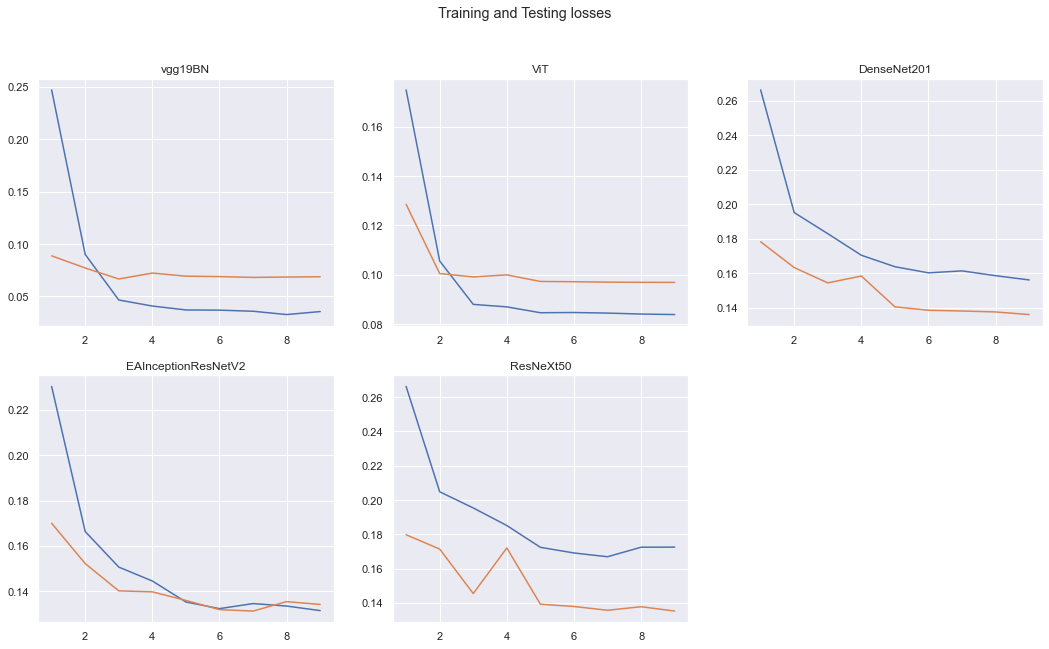

In [25]:


def plot_multi_model_losses():
    model_acc = {'vgg19BN':[loss_train_vgg, loss_test_vgg], 'ViT':[loss_train_vit, loss_test_vit],
                 'DenseNet201':[loss_train_dn, loss_test_dn], 'EAInceptionResNetV2':[loss_train_eairv, loss_test_eairv],
                 'ResNeXt50':[loss_train_rnx, loss_test_rnx]}
    sns.set()
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Training and Testing losses')
    idx = 0
    for x in range(2):
        for y in range(3):
            if idx < 5:
                sns.lineplot(ax=axes[x, y], x=range(1,10), y=model_acc[list(model_acc.keys())[idx]][0])
                sns.lineplot(ax=axes[x, y], x=range(1,10),
                             y=model_acc[list(model_acc.keys())[idx]][1]).set_title(list(model_acc.keys())[idx])
            idx += 1
    fig.delaxes(ax = axes[1,2])
            
            
plot_multi_model_losses()



In [26]:


def plot_confusion_matrix(preds, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    #getting the standard confusion matrix in text form
    cm = confusion_matrix(np.asarray(true_labels), np.asarray(preds))
    #using the matrix generated as means to plot a confusion matrix graphically
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Confusion matrix, without normalization


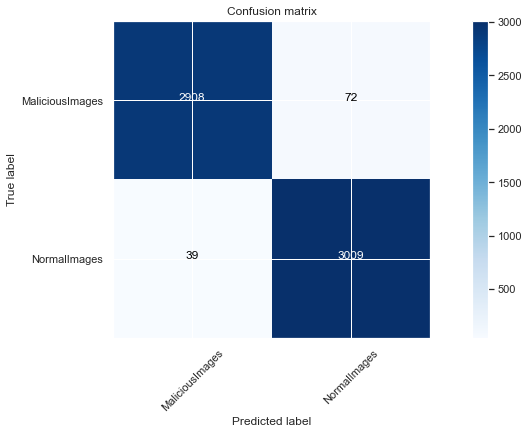

In [29]:

plot_confusion_matrix(vgg19_bn_hard, CLASSES)


Confusion matrix, without normalization


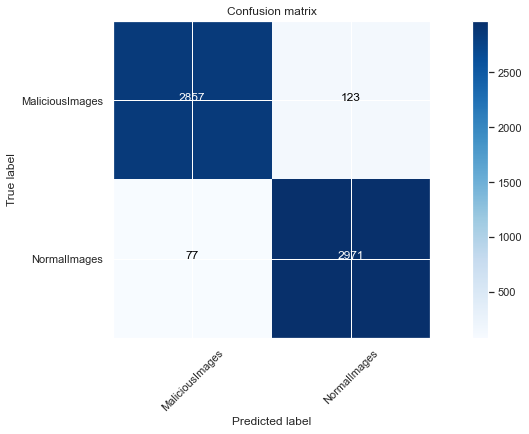

In [30]:


plot_confusion_matrix(vit_hard, CLASSES)



Confusion matrix, without normalization


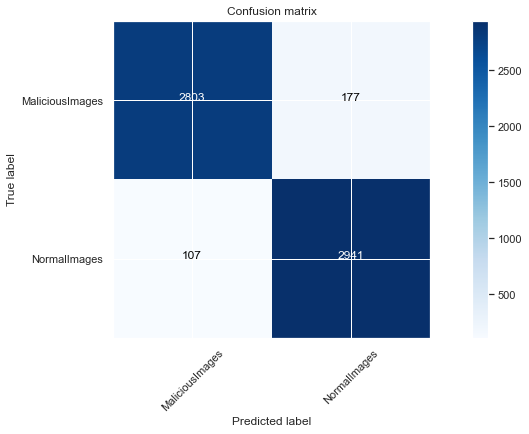

In [31]:


plot_confusion_matrix(densenet201_hard, CLASSES)



Confusion matrix, without normalization


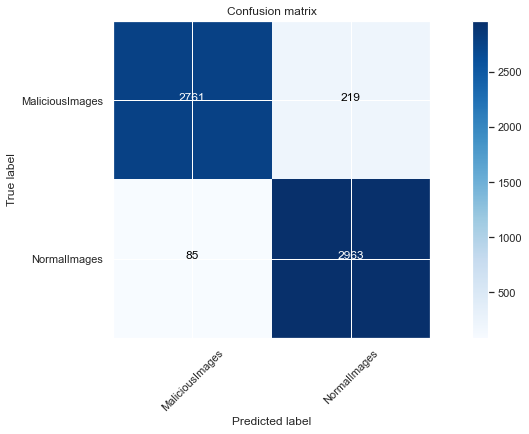

In [32]:


plot_confusion_matrix(ensemble_adv_incres_v2_hard, CLASSES)



Confusion matrix, without normalization


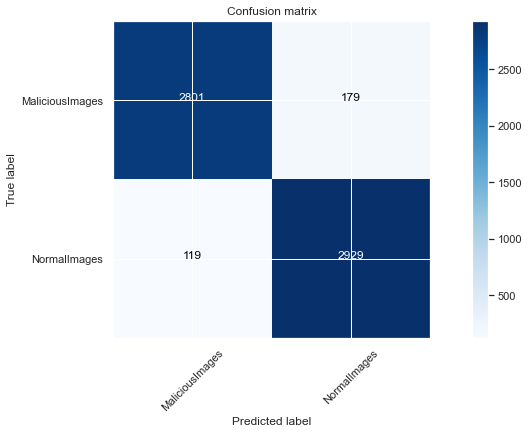

In [33]:
plot_confusion_matrix(resnext50_hard, CLASSES)

In [34]:
df_hard_voting = pd.DataFrame.from_dict({'vgg19_bn':vgg19_bn_hard, 'vit':vit_hard,
                    'densenet201':densenet201_hard, 'en_adv_incresv2':ensemble_adv_incres_v2_hard,
                    'resnext50':resnext50_hard})

In [35]:
df_soft_voting = pd.DataFrame.from_dict({'vgg19_bn_soft':vgg19_bn_soft, 'vit_soft':vit_soft,
                    'densenet201_soft':densenet201_soft, 'en_adv_incresv2_soft':ensemble_adv_incres_v2_soft,
                    'resnext50_soft':resnext50_soft})

In [36]:


ensemble_hard_predictions = np.asarray(df_hard_voting.mode(axis=1)[0])
ensemble_hard_score = accuracy_score(np.asarray(true_labels), ensemble_hard_predictions)
print(f"The Accuracy Score of Hard Voting Ensemble is:  {(ensemble_hard_score*100):.4f} %")



The Accuracy Score of Hard Voting Ensemble is:  96.7817 %


Confusion matrix, without normalization


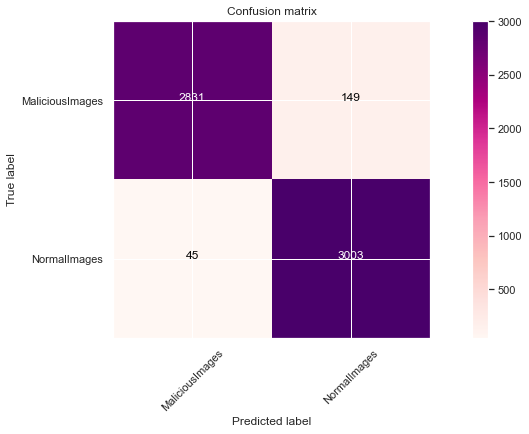

In [37]:
plot_confusion_matrix(ensemble_hard_predictions, CLASSES, cmap=plt.cm.RdPu)

In [38]:


def get_soft_voting():
    preds = []
    for x in range(len(df_soft_voting)):
        sample = (0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
        for y in range(len(df_soft_voting.columns)):
            sample = tuple(map(operator.add, sample, (tuple(df_soft_voting.iloc[x,y]))))
        sample = tuple(ti/len(sample) for ti in sample)
        element = max(sample)
        idx = sample.index(element)
        preds.append(idx)
    return preds

ensemble_soft_preds = get_soft_voting()
ensemble_soft_score = accuracy_score(np.asarray(true_labels), np.asarray(ensemble_soft_preds))
print(f"The Accuracy Score of Hard Voting Ensemble is:  {(ensemble_soft_score*100):.4f} %")



The Accuracy Score of Hard Voting Ensemble is:  97.1466 %


Confusion matrix, without normalization


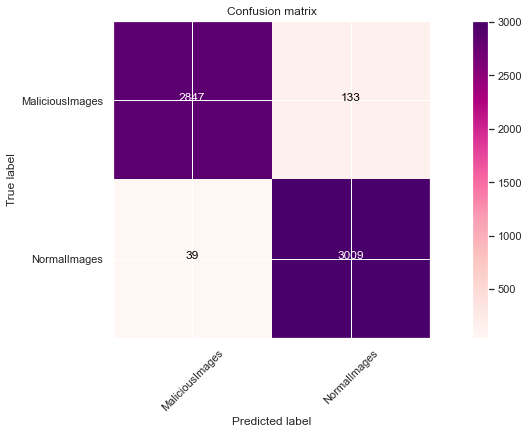

In [39]:


plot_confusion_matrix(ensemble_soft_preds, CLASSES, cmap=plt.cm.RdPu)



In [40]:
def get_weighted_average():
    preds = []
    weights = [0.2315, 0.973, 0.221, 0.189, 0.123]
    for x in range(len(df_soft_voting)):
        sample = (0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
        for y in range(len(df_soft_voting.columns)):
            ##
            k = tuple(float(weights[y]) * element for element in (tuple(df_soft_voting.iloc[x,y])))
            ##
            sample = tuple(map(operator.add, sample, k))
        sample = tuple(ti/len(sample) for ti in sample)
        element = max(sample)
        idx = sample.index(element)
        preds.append(idx)
    return preds

weighted_soft_preds = get_weighted_average()
weighted_soft_score = accuracy_score(np.asarray(true_labels), np.asarray(weighted_soft_preds))
print(f"The Accuracy Score of Hard Voting Ensemble is:  {(weighted_soft_score*100):.4f} %")

The Accuracy Score of Hard Voting Ensemble is:  97.1798 %


Confusion matrix, without normalization


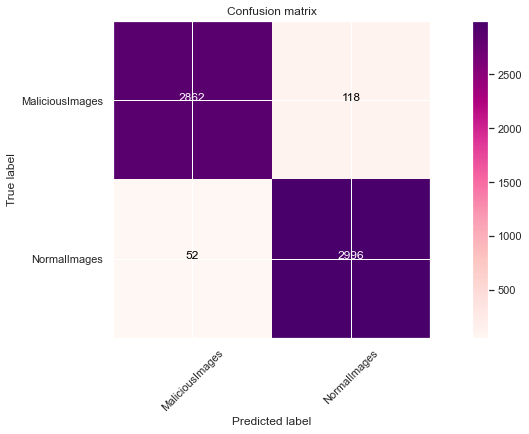

In [41]:


plot_confusion_matrix(weighted_soft_preds, CLASSES, cmap=plt.cm.RdPu)



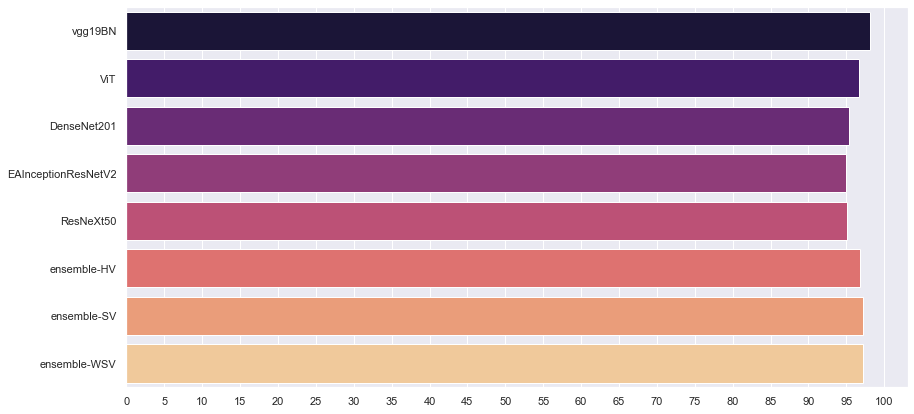

In [42]:
def plot_final_accuracies():
    scores = []
    model_acc = {'vgg19BN':vgg19_bn_hard, 'ViT':vit_hard, 'DenseNet201':densenet201_hard,
                 'EAInceptionResNetV2':ensemble_adv_incres_v2_hard, 'ResNeXt50':resnext50_hard,
                 'ensemble-HV':ensemble_hard_predictions, 'ensemble-SV':ensemble_soft_preds,
                 'ensemble-WSV':weighted_soft_preds}
    for model_pred in model_acc.values():
        scores.append((accuracy_score(true_labels, model_pred))*100)
    sns.set_theme(style="whitegrid")
    sns.set(rc={'figure.figsize':(14,7)})
    ax = sns.barplot(y=list(model_acc.keys()), x=scores, palette="magma", orient='h')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

plot_final_accuracies()